In [24]:
from typing import Tuple
import pickle

import keras.regularizers
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from experiments.util import load_data

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras import layers, activations, Sequential, losses

In [25]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

In [26]:
from skimage import feature
import matplotlib.pyplot as plt

import pandas as pd
from experiments.util import load_data

from sklearn.model_selection import train_test_split

import numpy as np

In [30]:
X_data, y_data = load_data()

# Daten laden und aufteilen in Features und Labels
with open('../../data/train_new.pkl', 'rb') as f:
    data_train = pickle.load(f)
X_data_new = data_train["images"]
y_data_new = data_train["labels"]

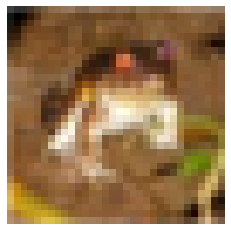

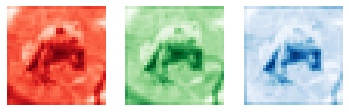

In [28]:
image = X_data[0, :, :, :]
plt.imshow(image)
plt.axis('off')
plt.show()
_, axes = plt.subplots(nrows=1, ncols=3)
axes[0].imshow(image[:, :, 0], cmap='Reds')
axes[0].axis('off')
axes[1].imshow(image[:, :, 1], cmap='Greens')
axes[1].axis('off')
axes[2].imshow(image[:, :, 2], cmap='Blues')
axes[2].axis('off')
plt.show()

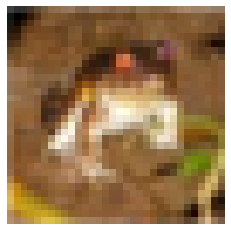

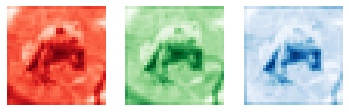

In [31]:
image = X_data_new[0, :, :, :]
plt.imshow(image)
plt.axis('off')
plt.show()
_, axes = plt.subplots(nrows=1, ncols=3)
axes[0].imshow(image[:, :, 0], cmap='Reds')
axes[0].axis('off')
axes[1].imshow(image[:, :, 1], cmap='Greens')
axes[1].axis('off')
axes[2].imshow(image[:, :, 2], cmap='Blues')
axes[2].axis('off')
plt.show()

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, random_state=42)

X_train = X_train / 255.0
X_val = X_val / 255.0

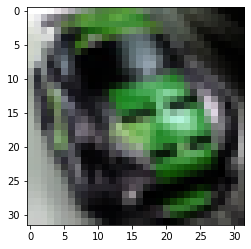

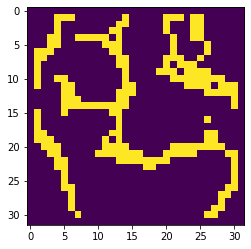

In [6]:
def edge_detection(image):
    r_image = image[:, :, 0]
    g_image = image[:, :, 1]
    b_image = image[:, :, 2]
    edge_image = feature.canny(r_image, sigma=3)
    edge_image = edge_image + feature.canny(g_image, sigma=3)
    edge_image = edge_image + feature.canny(b_image, sigma=3)
    return edge_image

image = X_train[5, :, :, :]
edge_image = edge_detection(image)
plt.imshow(image)
plt.show()
plt.imshow(edge_image)
plt.show()

In [ ]:
X_train_edges = np.array(list(map(edge_detection, X_train)))
X_val_edges = np.array(list(map(edge_detection, X_val)))

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

# Preprocess

red_channel = np.array([
    [1, 0, 0]
], dtype=np.float32)

green_channel = np.array([
    [0, 1, 0]
], dtype=np.float32)

blue_channel = np.array([
    [0, 0, 1]
], dtype=np.float32)

def preprocess(images, edge_images):
    center_mask = create_circular_mask(32, 32, center=None, radius=None)
    center_mask_3 = np.stack([center_mask] * 3, axis=2)
    small_center_mask = create_circular_mask(32, 32, center=None, radius=4)
    small_center_mask_3 = np.stack([small_center_mask] * 3, axis=2)
    big_center_mask = create_circular_mask(32, 32, center=None, radius=19)
    big_center_mask_3 = np.stack([big_center_mask] * 3, axis=2)
    center_images = np.where(center_mask_3, images, 0)
    border_images = np.where(~center_mask_3, images, 0)
    small_center_images = np.where(small_center_mask_3, images, 0)
    big_center_images = np.where(big_center_mask_3, images, 0)
    big_center_border_images = np.where(~big_center_mask_3, images, 0)
    center_edge_images = np.where(center_mask, edge_images, 0)
    return pd.DataFrame({
        'r': np.sum(images[:, :, :, 0], axis=(1,2)),
        'g': np.sum(images[:, :, :, 1], axis=(1,2)),
        'b': np.sum(images[:, :, :, 2], axis=(1,2)),
        'r_center': np.sum(center_images[:, :, :, 0], axis=(1,2)),
        'g_center': np.sum(center_images[:, :, :, 1], axis=(1,2)),
        'b_center': np.sum(center_images[:, :, :, 2], axis=(1,2)),
        'r_small_center': np.sum(small_center_images[:, :, :, 0], axis=(1,2)),
        'g_small_center': np.sum(small_center_images[:, :, :, 1], axis=(1,2)),
        'b_small_center': np.sum(small_center_images[:, :, :, 2], axis=(1,2)),
        'r_center_border': np.sum(border_images[:, :, :, 0], axis=(1,2)),
        'g_center_border': np.sum(border_images[:, :, :, 1], axis=(1,2)),
        'b_center_border': np.sum(border_images[:, :, :, 2], axis=(1,2)),
        'r_big_center_border_images': np.sum(big_center_border_images[:, :, :, 0], axis=(1,2)),
        'g_big_center_border_images': np.sum(big_center_border_images[:, :, :, 1], axis=(1,2)),
        'b_big_center_border_images': np.sum(big_center_border_images[:, :, :, 2], axis=(1,2)),
        'r_big_center_images': np.sum(big_center_images[:, :, :, 0], axis=(1,2)),
        'g_big_center_images': np.sum(big_center_images[:, :, :, 1], axis=(1,2)),
        'b_big_center_images': np.sum(big_center_images[:, :, :, 2], axis=(1,2)),
        'edges': np.sum(edge_images[:, :, :], axis=(1,2)),
        'edges_center': np.sum(center_edge_images[:, :, :], axis=(1,2)),
    })

X_train_preprocessed = preprocess(X_train, X_train_edges)

X_val_preprocessed = preprocess(X_val, X_val_edges)

lr = LogisticRegression(penalty='none')
lr.fit(X_train_preprocessed, y_train)

y_train_hat = lr.predict(X_train_preprocessed)
print("Train: ", accuracy_score(y_train_hat, y_train))

y_val_hat = lr.predict(X_val_preprocessed)
print("Val:   ", accuracy_score(y_val_hat, y_val))

In [ ]:
from skimage.feature import hog
from skimage import data, exposure


image = data.astronaut()

fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

X_train_hog = np.array(list(map(lambda x: exposure.rescale_intensity(x, in_range=(0, 10)), X_train)))
X_val_hog = np.array(list(map(lambda x: exposure.rescale_intensity(x, in_range=(0, 10)), X_val)))

In [ ]:
%%time

lr = LogisticRegression()
lr.fit(X_train_hog.reshape(-1, 32 * 32 * 3), y_train)

y_train_hat = lr.predict(X_train_hog.reshape(-1, 32 * 32 * 3))
print("Train: ", accuracy_score(y_train_hat, y_train))

y_val_hat = lr.predict(X_val_hog.reshape(-1, 32 * 32 * 3))
print("Val:   ", accuracy_score(y_val_hat, y_val))

In [ ]:
%%time

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline

lr = Pipeline([
    ('std', StandardScaler()),
    ('pca', PCA(n_components=200)),
    ('clf', LogisticRegression(max_iter=1000))
])
lr.fit(X_train_hog.reshape(-1, 32 * 32 * 3), y_train)

y_train_hat = lr.predict(X_train_hog.reshape(-1, 32 * 32 * 3))
print("Train: ", accuracy_score(y_train_hat, y_train))

y_val_hat = lr.predict(X_val_hog.reshape(-1, 32 * 32 * 3))
print("Val:   ", accuracy_score(y_val_hat, y_val))

In [ ]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)

In [ ]:
%%time

X_train_with_hog = np.concatenate([X_train_hog.reshape(-1, 32 * 32 * 3), X_train.reshape(-1, 32 * 32 * 3)], axis=1)
X_val_with_hog = np.concatenate([X_val_hog.reshape(-1, 32 * 32 * 3), X_val.reshape(-1, 32 * 32 * 3)], axis=1)

In [ ]:
%%time

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline

lr = Pipeline([
    ('std', StandardScaler()),
    ('pca', PCA(n_components=200)),
    ('clf', LogisticRegression(max_iter=1000))
])
lr.fit(X_train_with_hog, y_train)

y_train_hat = lr.predict(X_train_with_hog)
print("Train: ", accuracy_score(y_train_hat, y_train))

y_val_hat = lr.predict(X_val_with_hog)
print("Val:   ", accuracy_score(y_val_hat, y_val))

In [ ]:
%%time

from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline

lr = Pipeline([
    ('std', StandardScaler()),
    ('pca', PCA(n_components=200)),
    ('clf', RandomForestClassifier())
])
lr.fit(X_train_with_hog, y_train)

y_train_hat = lr.predict(X_train_with_hog)
print("Train: ", accuracy_score(y_train_hat, y_train))

y_val_hat = lr.predict(X_val_with_hog)
print("Val:   ", accuracy_score(y_val_hat, y_val))